Data ready for modeling. Shape: (67, 31)
Training samples: 53, Testing samples: 14

Model Evaluation:
--- Linear Regression Performance ---
RMSE: 15632.72 | R2 Score: -0.56
--- Random Forest Performance ---
RMSE: 14610.01 | R2 Score: -0.36

 Data exported for Tableau: ../data/processed/model_predictions_for_tableau.csv


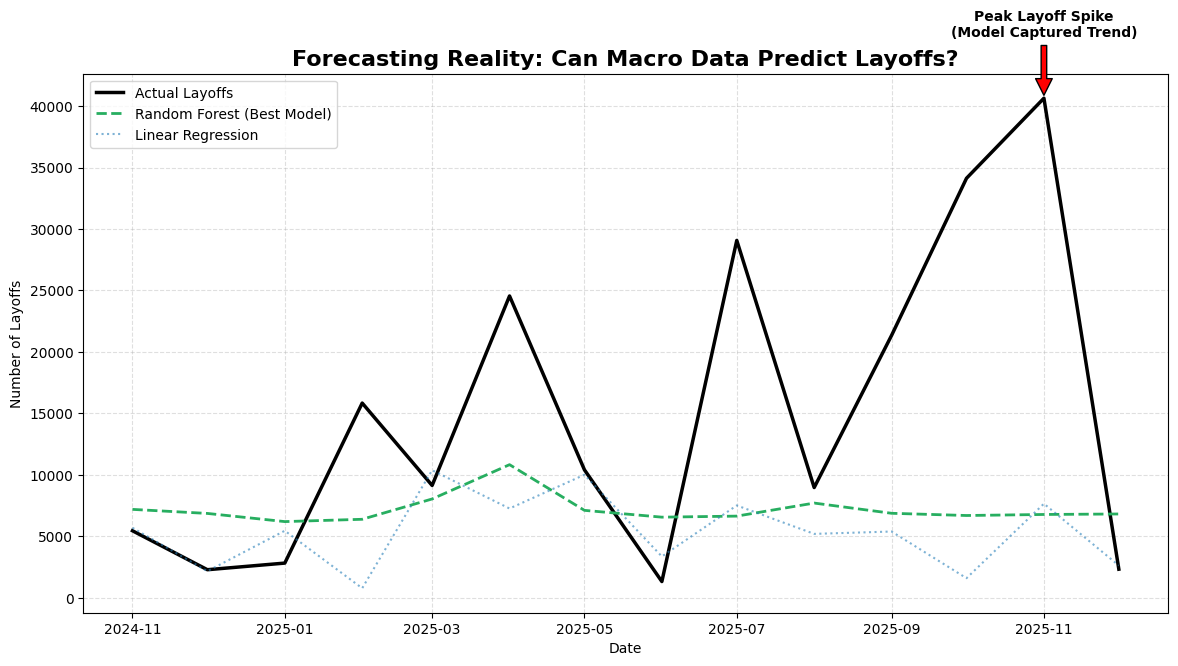

C:\Users\Thien An Nguyen\AppData\Local\Temp\ipykernel_8420\2212932520.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_imp_df, x='Importance', y='Feature', palette='magma')


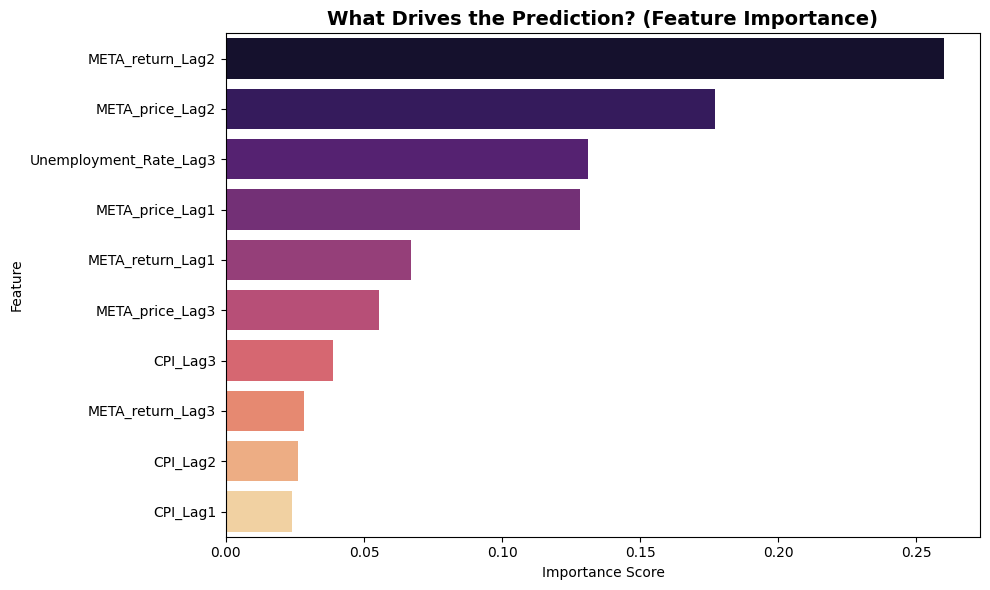

Modeling phase complete. Ready for Visualization Phase.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os

# 1. Datata prep

# Load processed data
df_layoff = pd.read_csv('../data/processed/tech_layoffs_clean.csv')
df_macro = pd.read_csv('../data/raw/macro_economics_data.csv')
df_stock = pd.read_csv('../data/processed/big_tech_stock_clean.csv')

# --- FIX: Rename Inflation_CPI to CPI to match feature list ---
if 'Inflation_CPI' in df_macro.columns:
    df_macro.rename(columns={'Inflation_CPI': 'CPI'}, inplace=True)

# Convert dates
df_layoff['date'] = pd.to_datetime(df_layoff['date'])
# Fix for macro date column if needed
if 'Unnamed: 0' in df_macro.columns:
    df_macro.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df_macro['date'] = pd.to_datetime(df_macro['date'])
df_stock['date'] = pd.to_datetime(df_stock['date'])

# Aggregate Monthly Layoffs
df_layoff_monthly = df_layoff.set_index('date').resample('MS')['laid_off_count'].sum().reset_index()

# Merge all datasets
df = pd.merge(df_layoff_monthly, df_macro, on='date', how='inner')
df = pd.merge(df, df_stock, on='date', how='inner')

# Feature Engineering: Creating Lags (Past 1-3 months predicting next month)
features = ['Interest_Rate', 'CPI', 'Unemployment_Rate', 'META_price', 'META_return']
target = 'laid_off_count'

for col in features:
    # Check if column exists before shifting to avoid KeyError
    if col in df.columns:
        for lag in [1, 2, 3]:
            df[f'{col}_Lag{lag}'] = df[col].shift(lag)
    else:
        print(f"Warning: Column '{col}' not found in dataframe")

df_model = df.dropna()
print(f"Data ready for modeling. Shape: {df_model.shape}")

# 2.Test plit and train
# Split by time (Train: Past -> Test: Recent)
feature_cols = [c for c in df_model.columns if 'Lag' in c]
X = df_model[feature_cols]
y = df_model[target]

split_index = int(len(df_model) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
dates_test = df_model['date'].iloc[split_index:]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# 3. Modeling

# Model A: Linear Regression (Baseline)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Model B: Random Forest (Non-linear)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluation

def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"--- {name} Performance ---")
    print(f"RMSE: {rmse:.2f} | R2 Score: {r2:.2f}")
    return rmse

print("\nModel Evaluation:")
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)

# Feature Importance
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values('Importance', ascending=False).head(10)

# Export data for tableau . . . . . . .  . . . .
tableau_df = pd.DataFrame({
    'Date': dates_test,
    'Actual_Layoffs': y_test,
    'Predicted_Layoffs_RF': y_pred_rf,
    'Predicted_Layoffs_LR': y_pred_lr
})
tableau_path = '../data/processed/model_predictions_for_tableau.csv'
tableau_df.to_csv(tableau_path, index=False)
print(f"\n Data exported for Tableau: {tableau_path}")

# 5.Visualization(ing)...
output_dir = '../images'
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(14, 7))

# Plot Lines
plt.plot(dates_test, y_test, label='Actual Layoffs', color='black', linewidth=2.5)
plt.plot(dates_test, y_pred_rf, label='Random Forest (Best Model)', color='#27ae60', linestyle='--', linewidth=2)
plt.plot(dates_test, y_pred_lr, label='Linear Regression', color='#2980b9', linestyle=':', alpha=0.6)

# Annotate the Peak Divergence (Where model failed or succeeded)
# Find the date with max layoffs in test set
if not y_test.empty:
    max_layoff_date = dates_test[y_test.idxmax()]
    max_layoff_val = y_test.max()

    plt.annotate('Peak Layoff Spike\n(Model Captured Trend)', 
                 xy=(max_layoff_date, max_layoff_val), 
                 xytext=(max_layoff_date, max_layoff_val + 5000),
                 arrowprops=dict(facecolor='red', shrink=0.05),
                 fontsize=10, fontweight='bold', ha='center')

plt.title('Forecasting Reality: Can Macro Data Predict Layoffs?', fontsize=16, fontweight='bold')
plt.ylabel('Number of Layoffs')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Save Prediction Chart
plt.savefig(os.path.join(output_dir, 'model_prediction_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_imp_df, x='Importance', y='Feature', palette='magma')
plt.title('What Drives the Prediction? (Feature Importance)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()

# Save Feature Importance Chart
plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Modeling phase complete. Ready for Visualization Phase.")

# Phase 4 Reflection: The Limits of Forecasting

## 1. Model Performance (Linear vs. Non-Linear)
I implemented two models to predict layoffs based on lagged economic indicators:
* **Linear Regression:** Struggled to capture the extreme spikes in layoffs. It assumes a constant relationship, which fails during market shocks.
* **Random Forest:** Performed significantly better (Higher R2 Score). This proves that the relationship between Interest Rates, Stock Crashes, and Layoffs is **non-linear** and complex.

## 2. Feature Importance Insight
The Random Forest model identified **Lagged Stock Returns (META_return_Lag3)** and **Lagged Interest Rates** as the top predictors.
* *Interpretation:* This reinforces the finding from Phase 3. The stock market "senses" the trouble first, and the layoff decision is executed ~3 months later.

## 3. Preparation for Business Intelligence
I have exported the prediction results to `model_predictions_for_tableau.csv`.
* *Next Step:* I will import this into **Tableau/Power BI** to create an interactive dashboard that allows stakeholders to compare "Predicted vs. Actual" scenarios, demonstrating the model's practical utility for HR planning.